## Crop Yield Recommendation Based on Soil and Climatic Conditions

### 1. Research Question
What are the optimal crops to grow based on soil nutrient levels (NPK), pH, and climatic factors (temperature, humidity, rainfall) to maximize yield?

### 2. Data Source
The data is sourced from Kaggle.
Link: https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset
Dataset contains features such as Nitrogen (N), Phosphorus (P), Potassium (K) content of soil, temperature, humidity, pH, and rainfall, along with corresponding crop names.

### 3. Techniques for Analysis

- **Exploratory Data Analysis (EDA):** To understand the relationships between soil, climate features, and crop yield.
- **Supervised Machine Learning:** Algorithms like Random Forest, Decision Trees, and k-Nearest Neighbors (k-NN) to build a classification model for crop recommendation.
- **Feature Engineering:** Creating new variables or optimizing existing ones (e.g., soil quality scores, weather indices).
- **Cross-Validation:** Ensuring model generalization and robustness.
- **Model Evaluation:**  Metrics such as accuracy, precision, recall, and F1-score will be used to validate the recommendation system.

### 4. Expected Results
- A reliable crop recommendation model that can predict the best crop for a given region based on the soil and climate conditions. The model should achieve high accuracy in predicting which crops will thrive under specific conditions, providing farmers with actionable insights.

- Crop rotation: Find a group of crops that can grow in similar soil and climate conditions

### 5. Importance of This Question
In many parts of the world, farmers rely on traditional knowledge or trial-and-error methods to determine which crops to plant. However, with changing climatic conditions and varying soil fertility, this approach is often inefficient, leading to suboptimal yields and economic losses.

This research is important because it provides data-driven recommendations that can optimize crop selection, increasing agricultural productivity and sustainability. If the question goes unanswered, farmers may continue to use less efficient methods, leading to reduced yields, wasted resources, and financial strain. On the other hand, actionable insights from this project will empower non-technical agricultural personnel to make informed decisions, ensuring better crop management, maximizing yields, and improving food security.

### Import and Setup

In [206]:
# Imports

import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (StackingClassifier, RandomForestClassifier)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, accuracy_score, 
                             ConfusionMatrixDisplay, f1_score)
from sklearn.inspection import permutation_importance
from sklearn.exceptions import ConvergenceWarning

In [207]:
# Ignore convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Data Overview

In [208]:
crop = pd.read_csv("Crop_recommendation.csv")

In [209]:
crop.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [210]:
crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [211]:
crop.isnull().values.any()

False

In [212]:
crop['label'].value_counts()

label
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: count, dtype: int64

### Build the Recommendation Machine Learning Model
Utilize different supervised machine learning classifiers to develop a model that achieves improved accuracy. This model will assist farmers in determining which crops are suitable for cultivation based on specific soil and climate conditions.

The classification methods used are:
- 1. KNN
- 2. Logistic Regression
- 3. Decision Tree
- 4. Support Vector Machine

In [213]:
# Use 'label' i.e the crop name as input target label and all other features as input
X = crop.drop('label', axis=1)
y = crop['label']

In [214]:
# Split the dataset into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [215]:
transformer = make_column_transformer((StandardScaler(), X.columns.tolist()), remainder='passthrough')

## 1. KNN classifier

In [216]:
# Build a pipeline of transformer and KNN classifier. Using GridSearchCV to find the optimal paramaters

knn_pipe = Pipeline([('transform', transformer), ('knn', KNeighborsClassifier())])
params = {'knn__n_neighbors': list(range(1, 22)),
          'knn__weights': ['uniform', 'distance'],
          'knn__p': [1,2]}
knn_grid = GridSearchCV(knn_pipe, param_grid=params)
knn_grid.fit(X_train, y_train)
best_k = list(knn_grid.best_params_.values())[0]
best_acc = knn_grid.score(X_test, y_test)
print("done")
print(best_k)
print(best_acc)
print(knn_grid.best_params_)

done
1
0.9712121212121212
{'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'uniform'}


In [217]:
y_pred_knn = knn_grid.predict(X_test)

In [218]:
# Helper method to plot confusion matrix, given a model
def plot_confusion_matrix(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    # Normalize the confusion matrix
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Set up the figure and axes for plotting
    plt.figure(figsize=(12, 10))

    # Create a heatmap with annotations
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=True,
                xticklabels=np.unique(y), yticklabels=np.unique(y))

    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

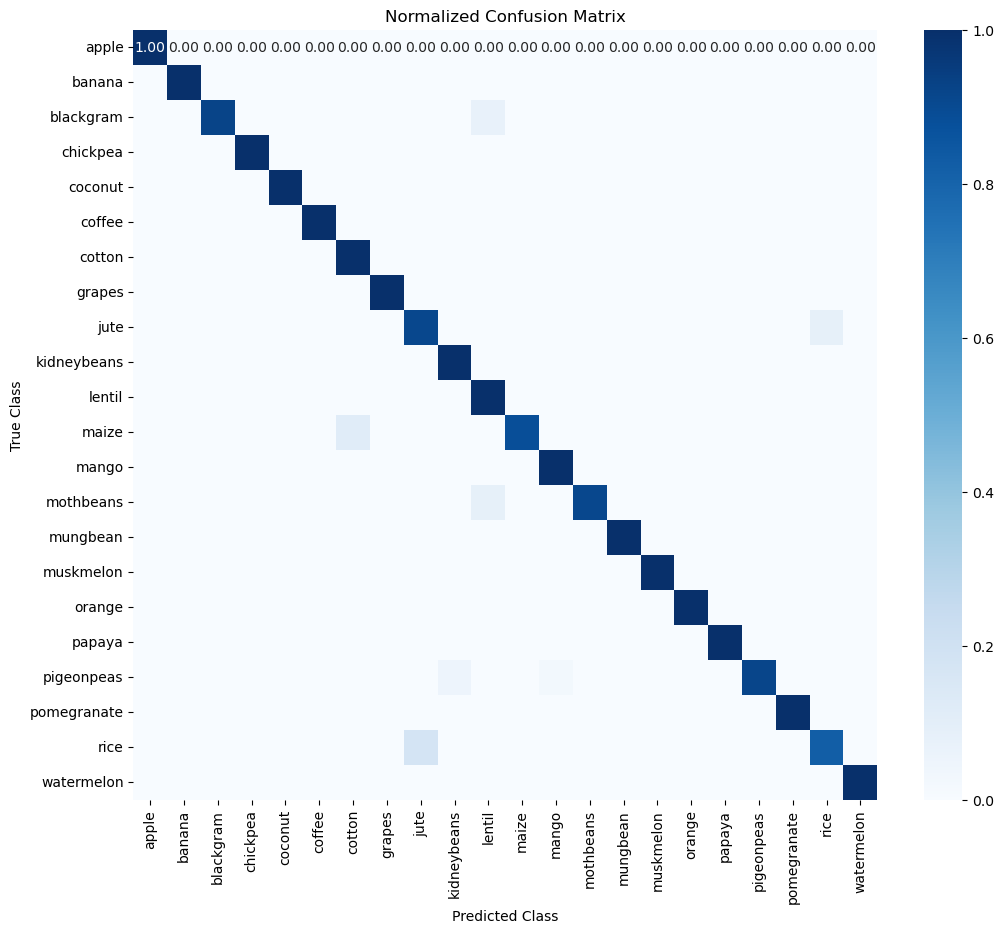

In [219]:
plot_confusion_matrix(y_test, y_pred_knn)

In [220]:
# Helper method to get the F1-Scores of all classes, given a classifier
def get_f1_scores(y_test, y_pred):
    f1_score_map = {}
    f1_scores = f1_score(y_test, y_pred, average=None)
    classes = crop['label'].unique()
    for i, class_name in enumerate(classes):
        f1_score_map[class_name] = f1_scores[i]
        
    return f1_score_map

In [221]:
# Evaluate the KNN model. Get the Accuracy, F1 scores, Macro F1 score and weighted F1 score
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_f1_scores = get_f1_scores(y_test, y_pred_knn)
knn_macro_f1_score = f1_score(y_test, y_pred_knn, average='macro')
knn_weighted_f1_score = f1_score(y_test, y_pred_knn, average='weighted')
print(f'KNN Accuracy: {knn_accuracy:.2f}')
print(f'KNN Macro F1 score: {knn_macro_f1_score:.2f}')
print(f'KNN Weighted F1 score: {knn_weighted_f1_score:.2f}')
print('KNN F1 scores for each class:')
print(knn_f1_scores)

KNN Accuracy: 0.97
KNN Macro F1 score: 0.97
KNN Weighted F1 score: 0.97
KNN F1 scores for each class:
{'rice': 1.0, 'maize': 1.0, 'chickpea': 0.9600000000000001, 'kidneybeans': 1.0, 'pigeonpeas': 1.0, 'mothbeans': 1.0, 'mungbean': 0.9491525423728813, 'blackgram': 1.0, 'lentil': 0.8857142857142858, 'pomegranate': 0.972972972972973, 'banana': 0.8979591836734693, 'mango': 0.9387755102040816, 'grapes': 0.9846153846153847, 'watermelon': 0.9538461538461539, 'muskmelon': 1.0, 'apple': 1.0, 'orange': 1.0, 'papaya': 1.0, 'coconut': 0.9577464788732395, 'cotton': 1.0, 'jute': 0.8518518518518519, 'coffee': 1.0}


## 2. Logistic Regression

In [222]:
# Build a pipeline of transformer and Logistic Regressor. Using GridSearchCV to find the optimal paramaters
lgr_pipe = Pipeline([('transform', transformer), ('lgr', LogisticRegression(random_state=42))])
params = {'lgr__C': [0.01, 0.1, 1, 10, 100],
          'lgr__penalty': ['l1', 'l2'],
          'lgr__multi_class': ['ovr', 'multinomial'],
          'lgr__solver': ['lbfgs', 'saga'],
          'lgr__max_iter': [100, 200, 300]}
lgr_grid = GridSearchCV(lgr_pipe, param_grid=params)
lgr_grid.fit(X_train, y_train)
best_params = lgr_grid.best_params_
best_score = lgr_grid.best_score_
print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Score: {best_score:.2f}')

# Use the best estimator to make predictions
best_model = lgr_grid.best_estimator_
y_pred_lgr = best_model.predict(X_test)

Best Parameters: {'lgr__C': 100, 'lgr__max_iter': 100, 'lgr__multi_class': 'multinomial', 'lgr__penalty': 'l2', 'lgr__solver': 'lbfgs'}
Best Cross-Validation Score: 0.98


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

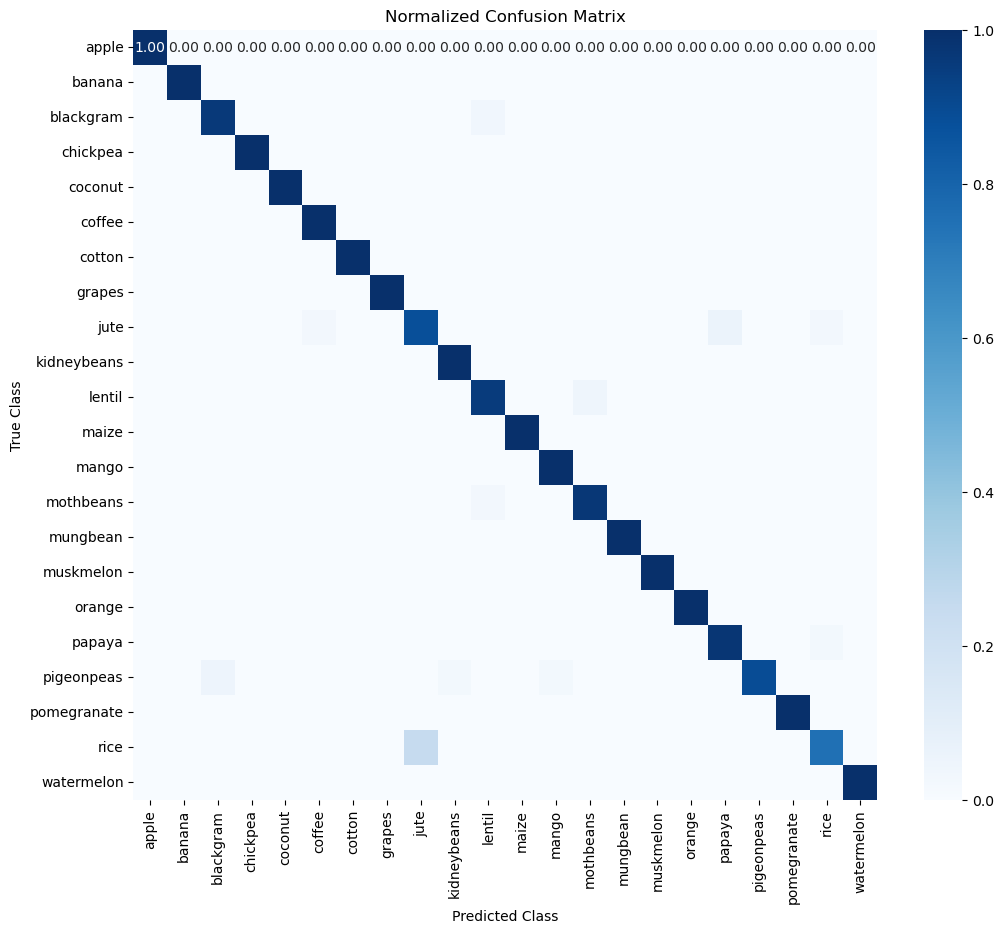

In [223]:
plot_confusion_matrix(y_test, y_pred_lgr)

In [224]:
# Evaluate the Logistic Regression model. Get the Accuracy, F1 scores, Macro F1 score and weighted F1 score
lgr_accuracy = accuracy_score(y_test, y_pred_lgr)
lgr_f1_scores = get_f1_scores(y_test, y_pred_lgr)
lgr_macro_f1_score = f1_score(y_test, y_pred_lgr, average='macro')
lgr_weighted_f1_score = f1_score(y_test, y_pred_lgr, average='weighted')
print(f'Logistic Regression Accuracy: {lgr_accuracy:.2f}')
print(f'Logistic Regression Macro F1 score: {lgr_macro_f1_score:.2f}')
print(f'Logistic Regression Weighted F1 score: {lgr_weighted_f1_score:.2f}')
print('Logistic Regression F1 scores for each class:')
print(lgr_f1_scores)

Logistic Regression Accuracy: 0.97
Logistic Regression Macro F1 score: 0.97
Logistic Regression Weighted F1 score: 0.97
Logistic Regression F1 scores for each class:
{'rice': 1.0, 'maize': 1.0, 'chickpea': 0.9433962264150944, 'kidneybeans': 1.0, 'pigeonpeas': 1.0, 'mothbeans': 0.9836065573770492, 'mungbean': 1.0, 'blackgram': 1.0, 'lentil': 0.8450704225352113, 'pomegranate': 0.9863013698630138, 'banana': 0.9333333333333332, 'mango': 1.0, 'grapes': 0.9846153846153847, 'watermelon': 0.9705882352941176, 'muskmelon': 1.0, 'apple': 1.0, 'orange': 1.0, 'papaya': 0.9599999999999999, 'coconut': 0.9428571428571428, 'cotton': 1.0, 'jute': 0.8235294117647057, 'coffee': 1.0}


## 3. Decision Tree Classifier

In [225]:
# Build a pipeline of transformer and Decision Tree Classification.
# Using GridSearchCV to find the optimal paramaters
params = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss']
}
dt_pipe = Pipeline([
    ('classifier', DecisionTreeClassifier(random_state=42))
])
dt_grid = GridSearchCV(dt_pipe, param_grid=params).fit(X_train, y_train)
dt_grid.best_params_
y_pred_dt = dt_grid.predict(X_test)

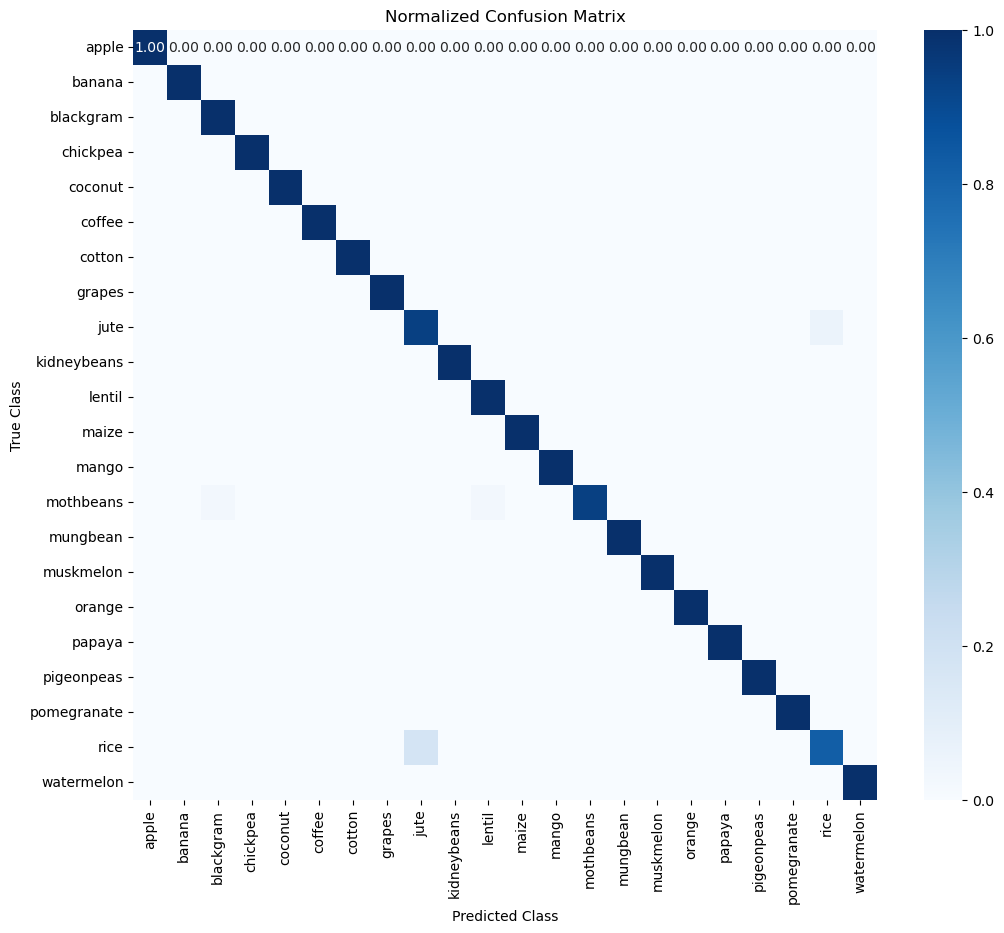

In [226]:
plot_confusion_matrix(y_test, y_pred_dt)

In [227]:
# Evaluate the Decision Tree model. Get the Accuracy, F1 scores, Macro F1 score and weighted F1 score
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_f1_scores = get_f1_scores(y_test, y_pred_dt)
dt_macro_f1_score = f1_score(y_test, y_pred_dt, average='macro')
dt_weighted_f1_score = f1_score(y_test, y_pred_dt, average='weighted')
print(f'Decision Tree Accuracy: {dt_accuracy:.2f}')
print(f'Decision Tree Macro F1 score: {dt_macro_f1_score:.2f}')
print(f'Decision Tree Weighted F1 score: {dt_weighted_f1_score:.2f}')
print('Decision Tree F1 scores for each class:')
print(dt_f1_scores)

Decision Tree Accuracy: 0.99
Decision Tree Macro F1 score: 0.99
Decision Tree Weighted F1 score: 0.99
Decision Tree F1 scores for each class:
{'rice': 1.0, 'maize': 1.0, 'chickpea': 0.9811320754716981, 'kidneybeans': 1.0, 'pigeonpeas': 1.0, 'mothbeans': 1.0, 'mungbean': 1.0, 'blackgram': 1.0, 'lentil': 0.9014084507042254, 'pomegranate': 1.0, 'banana': 0.9777777777777777, 'mango': 1.0, 'grapes': 1.0, 'watermelon': 0.9696969696969697, 'muskmelon': 1.0, 'apple': 1.0, 'orange': 1.0, 'papaya': 1.0, 'coconut': 1.0, 'cotton': 1.0, 'jute': 0.8679245283018867, 'coffee': 1.0}


## 4. Support Vector Machine

In [228]:
# Build a pipeline of transformer and Support Vector Machine Classifier.
# Using GridSearchCV to find the optimal paramaters
svm_pipe = Pipeline([
    ('transformer', transformer),
    ('classifier', SVC())
])
params = {
    'classifier__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
    'classifier__gamma': [0.1, 1.0, 10.0, 100.0]
}
svm_grid = GridSearchCV(svm_pipe, param_grid=params).fit(X_train, y_train)
svm_grid_score = svm_grid.score(X_test, y_test)
svm_grid.best_params_
y_pred_svm = svm_grid.predict(X_test)

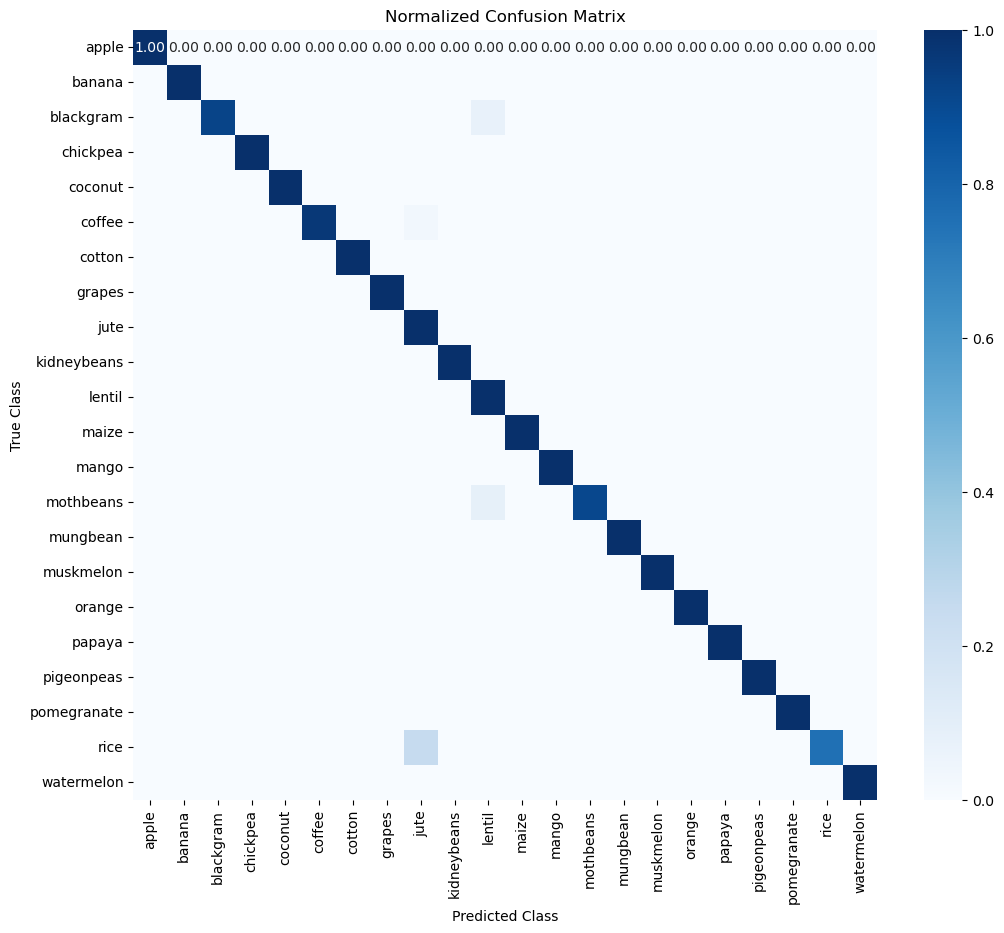

In [229]:
plot_confusion_matrix(y_test, y_pred_svm)

In [230]:
# Evaluate the Decision Tree model. Get the Accuracy, F1 scores, Macro F1 score and weighted F1 score
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_f1_scores = get_f1_scores(y_test, y_pred_svm)
svm_macro_f1_score = f1_score(y_test, y_pred_svm, average='macro')
svm_weighted_f1_score = f1_score(y_test, y_pred_svm, average='weighted')
print(f'SVM Accuracy: {svm_accuracy:.2f}')
print(f'SVM Macro F1 score: {svm_macro_f1_score:.2f}')
print(f'SVM Weighted F1 score: {svm_weighted_f1_score:.2f}')
print('SVM F1 scores for each class:')
print(svm_f1_scores)

SVM Accuracy: 0.98
SVM Macro F1 score: 0.98
SVM Weighted F1 score: 0.98
SVM F1 scores for each class:
{'rice': 1.0, 'maize': 1.0, 'chickpea': 0.9600000000000001, 'kidneybeans': 1.0, 'pigeonpeas': 1.0, 'mothbeans': 0.983050847457627, 'mungbean': 1.0, 'blackgram': 1.0, 'lentil': 0.8947368421052632, 'pomegranate': 1.0, 'banana': 0.8979591836734693, 'mango': 1.0, 'grapes': 1.0, 'watermelon': 0.9538461538461539, 'muskmelon': 1.0, 'apple': 1.0, 'orange': 1.0, 'papaya': 1.0, 'coconut': 1.0, 'cotton': 1.0, 'jute': 0.8571428571428571, 'coffee': 1.0}


### Plot F1 scores from individual models

In [231]:
# Get the list of all crop labels
crop_labels = crop['label'].unique()
print(crop_labels)

['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']


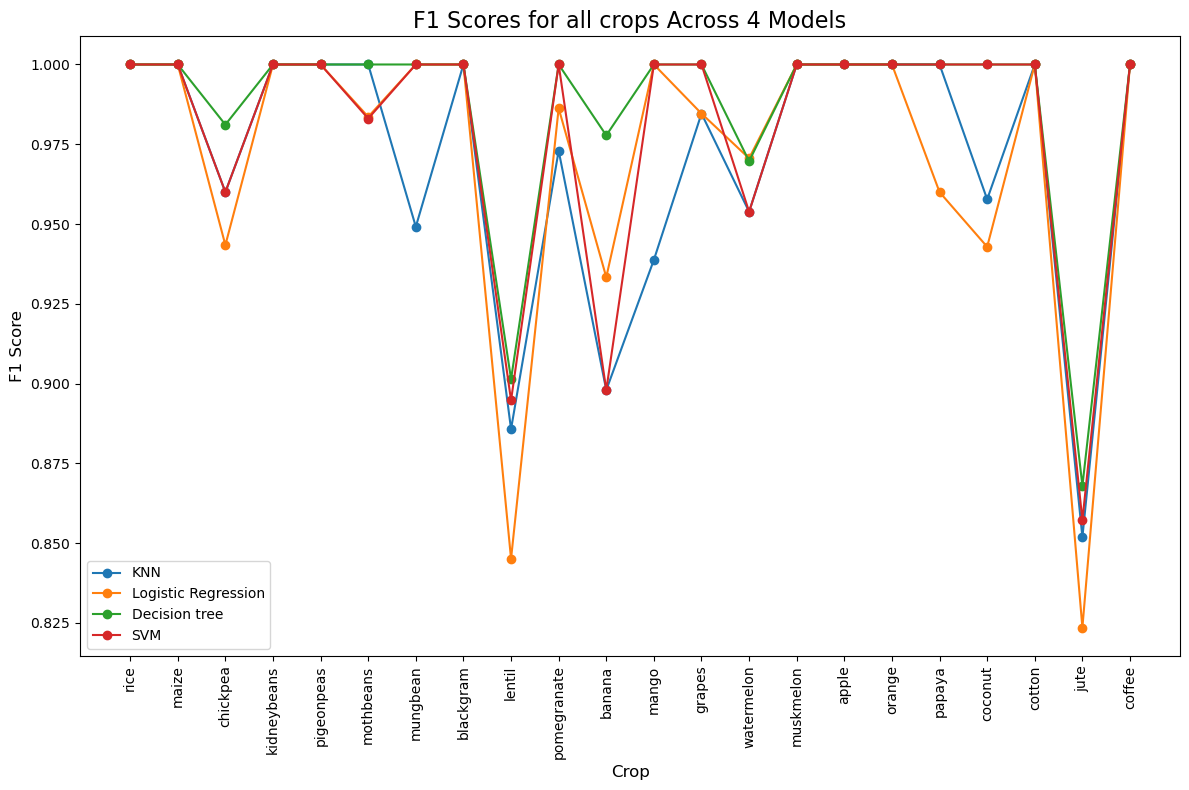

In [232]:
# Plot Line chart to visualize F1 scores of crop labels from above 4 models
f1_scores = {
    'KNN': knn_f1_scores.values(),
    'Logistic Regression': lgr_f1_scores.values(),
    'Decision tree': dt_f1_scores.values(),
    'SVM': svm_f1_scores.values()
}

# Define the figure size
plt.figure(figsize=(12, 8))

# Plot F1 scores for each model as a line
for model, scores in f1_scores.items():
    plt.plot(crop_labels, scores, marker='o', label=model)

# Adding labels and title
plt.xlabel('Crop', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('F1 Scores for all crops Across 4 Models', fontsize=16)

# Rotate class names on x-axis
plt.xticks(rotation=90)

# Add a legend to differentiate the models
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [233]:
# Calculate accuracy for each model
model_accuracy = {
    'Model': ['Logistic Regression', 'Decision Tree', 'SVM', 'KNN'],
    'Accuracy': [lgr_accuracy, dt_accuracy, svm_accuracy, knn_accuracy],
    'Macro F1 score': [lgr_macro_f1_score, dt_macro_f1_score, svm_macro_f1_score, knn_macro_f1_score], 
    'Weighted F1 score': [lgr_weighted_f1_score, dt_weighted_f1_score, svm_weighted_f1_score, knn_weighted_f1_score]
}

# Display the results
accuracy_df = pd.DataFrame(model_accuracy)
print(accuracy_df)

                 Model  Accuracy  Macro F1 score  Weighted F1 score
0  Logistic Regression  0.971212        0.971514           0.970881
1        Decision Tree  0.986364        0.986270           0.986273
2                  SVM  0.980303        0.979397           0.980392
3                  KNN  0.971212        0.970574           0.971315


### Analysis
Decision Tree gave the highest accuracy and can be chosen as the best model among the 4. However, lets use stacking classifier to check if we get better accuracy.

## Stacking Classifiers
Stacking classifiers, also known as stacked generalization, is an ensemble learning technique that combines multiple machine learning models to improve predictive performance. Lets use these to get better accuracy with same base models and different final estimators

## 5. Stacking Classifier with Logistic Regression

In [234]:
# Use KNN, Logistic Regression, Support Vector Machine and Decision Tree Classifiers with the best params
# from above as base models to stacking classifier.

base_models = [
    ('knn', knn_grid),
    ('lgr', lgr_grid),
    ('svc', svm_grid),
    ('dt', dt_grid)
]

# Logistic Regression as meta model
meta_model = LogisticRegression()

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacking_clf.fit(X_train, y_train)
y_pred_sc_lgr = stacking_clf.predict(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

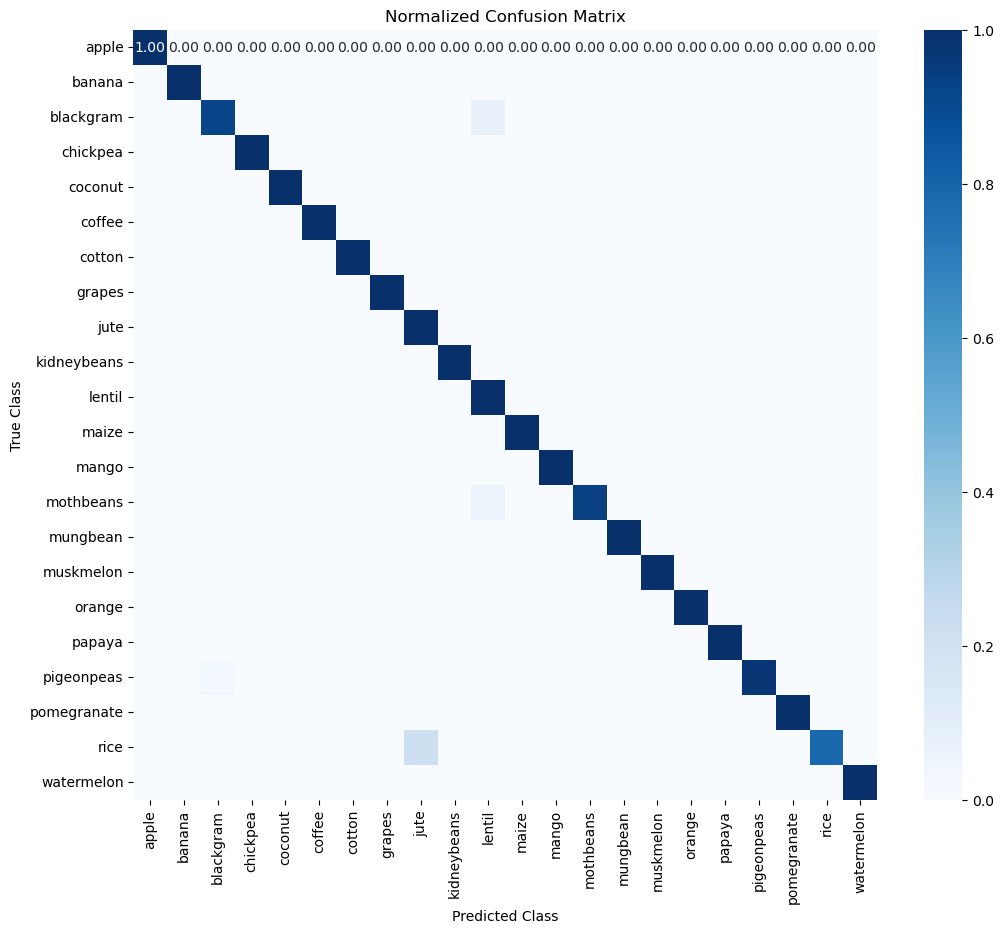

In [235]:
plot_confusion_matrix(y_test, y_pred_sc_lgr)

In [236]:
# Evaluate the Stacking Classifier with Logistic Regression. Get the Accuracy, F1 scores, Macro F1 score and weighted F1 score
sc_lgr_accuracy = accuracy_score(y_test, y_pred_sc_lgr)
sc_lgr_f1_scores = get_f1_scores(y_test, y_pred_sc_lgr)
sc_lgr_macro_f1_score = f1_score(y_test, y_pred_sc_lgr, average='macro')
sc_lgr_weighted_f1_score = f1_score(y_test, y_pred_sc_lgr, average='weighted')
print(f'Stacking Classifier with Logistic Regressor Accuracy: {sc_lgr_accuracy:.2f}')
print(f'Stacking Classifier with Logistic Regressor Macro F1 score: {sc_lgr_macro_f1_score:.2f}')
print(f'Stacking Classifier with Logistic Regressor Weighted F1 score: {sc_lgr_weighted_f1_score:.2f}')
print('Stacking Classifier with Logistic Regressor F1 scores for each class:')
print(sc_lgr_f1_scores)

Stacking Classifier with Logistic Regressor Accuracy: 0.98
Stacking Classifier with Logistic Regressor Macro F1 score: 0.98
Stacking Classifier with Logistic Regressor Weighted F1 score: 0.98
Stacking Classifier with Logistic Regressor F1 scores for each class:
{'rice': 1.0, 'maize': 1.0, 'chickpea': 0.9411764705882353, 'kidneybeans': 1.0, 'pigeonpeas': 1.0, 'mothbeans': 1.0, 'mungbean': 1.0, 'blackgram': 1.0, 'lentil': 0.9189189189189189, 'pomegranate': 1.0, 'banana': 0.9166666666666666, 'mango': 1.0, 'grapes': 1.0, 'watermelon': 0.9696969696969697, 'muskmelon': 1.0, 'apple': 1.0, 'orange': 1.0, 'papaya': 1.0, 'coconut': 0.9863013698630138, 'cotton': 1.0, 'jute': 0.88, 'coffee': 1.0}


## 6. Stacking Classifier with SVM

In [237]:
# Use KNN, Logistic Regression, Support Vector Machine and Decision Tree Classifiers with the best params
# from above as base models to stacking classifier.
base_models = [
    ('knn', knn_grid),
    ('lgr', lgr_grid),
    ('svc', svm_grid),
    ('dt', dt_grid)
]

# Support Vector Machine classifier as meta model
meta_model = SVC(random_state=42)

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacking_clf.fit(X_train, y_train)
y_pred_sc_svm = stacking_clf.predict(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

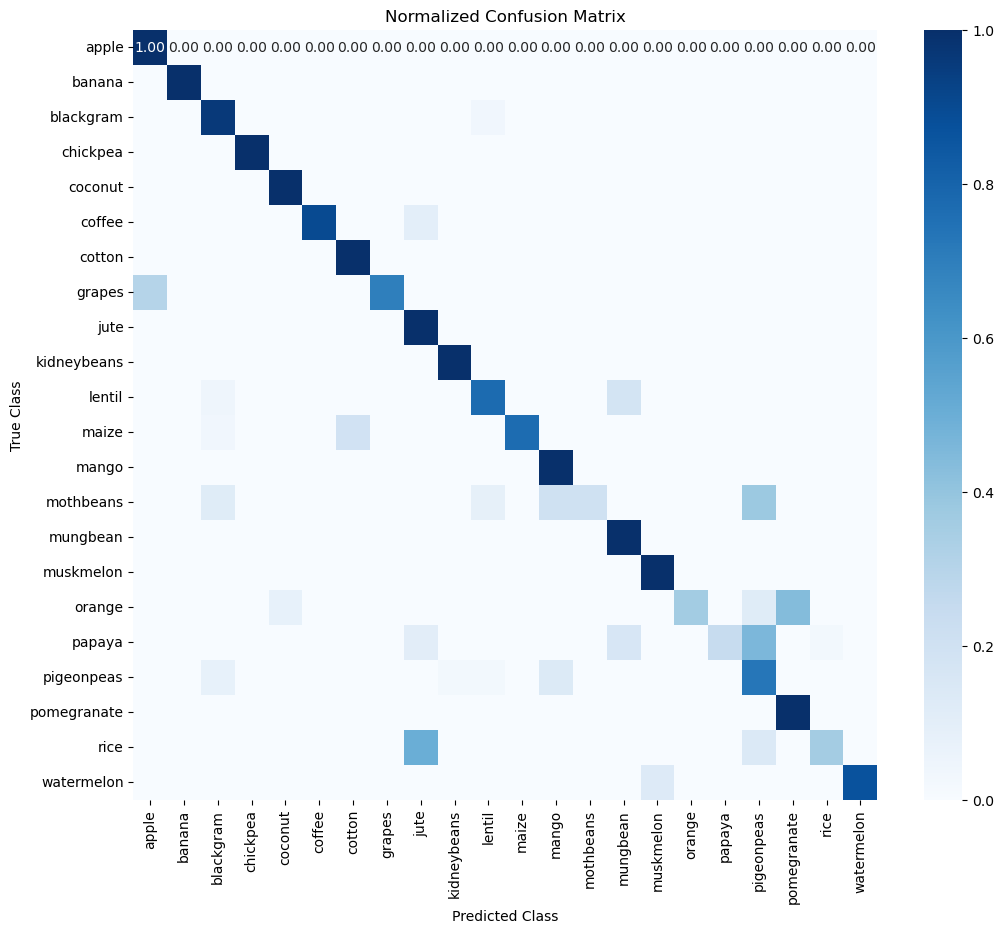

In [238]:
plot_confusion_matrix(y_test, y_pred_sc_svm)

In [239]:
# Evaluate the Stacking Classifier with SVM. Get the Accuracy, F1 scores, Macro F1 score and weighted F1 score
sc_svm_accuracy = accuracy_score(y_test, y_pred_sc_svm)
sc_svm_f1_scores = get_f1_scores(y_test, y_pred_sc_svm)
sc_svm_macro_f1_score = f1_score(y_test, y_pred_sc_svm, average='macro')
sc_svm_weighted_f1_score = f1_score(y_test, y_pred_sc_svm, average='weighted')
print(f'Stacking Classifier with SVM Accuracy: {sc_svm_accuracy:.2f}')
print(f'Stacking Classifier with SVM Macro F1 score: {sc_svm_macro_f1_score:.2f}')
print(f'Stacking Classifier with SVM Weighted F1 score: {sc_svm_weighted_f1_score:.2f}')
print('Stacking Classifier with SVM F1 scores for each class:')
print(sc_svm_f1_scores)

Stacking Classifier with SVM Accuracy: 0.81
Stacking Classifier with SVM Macro F1 score: 0.80
Stacking Classifier with SVM Weighted F1 score: 0.79
Stacking Classifier with SVM F1 scores for each class:
{'rice': 0.9066666666666667, 'maize': 1.0, 'chickpea': 0.8333333333333333, 'kidneybeans': 1.0, 'pigeonpeas': 0.9705882352941176, 'mothbeans': 0.9473684210526316, 'mungbean': 0.9180327868852458, 'blackgram': 0.8205128205128205, 'lentil': 0.7640449438202247, 'pomegranate': 0.9863013698630138, 'banana': 0.7727272727272727, 'mango': 0.8695652173913044, 'grapes': 0.8421052631578948, 'watermelon': 0.34146341463414637, 'muskmelon': 0.8571428571428571, 'apple': 0.9411764705882353, 'orange': 0.5294117647058824, 'papaya': 0.391304347826087, 'coconut': 0.5346534653465346, 'cotton': 0.8735632183908045, 'jute': 0.5128205128205129, 'coffee': 0.9302325581395349}


## 7. Stacking Classifier with Random Forest

In [240]:
# Use KNN, Logistic Regression, Support Vector Machine and Decision Tree Classifiers with the best params
# from above as base models to stacking classifier.
base_models = [
    ('knn', knn_grid),
    ('lgr', lgr_grid),
    ('svc', svm_grid),
    ('dt', dt_grid)
]

# Random Forest classifier as meta model
meta_model = RandomForestClassifier(random_state=42)
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacking_clf.fit(X_train, y_train)
y_pred_sc_rf = stacking_clf.predict(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

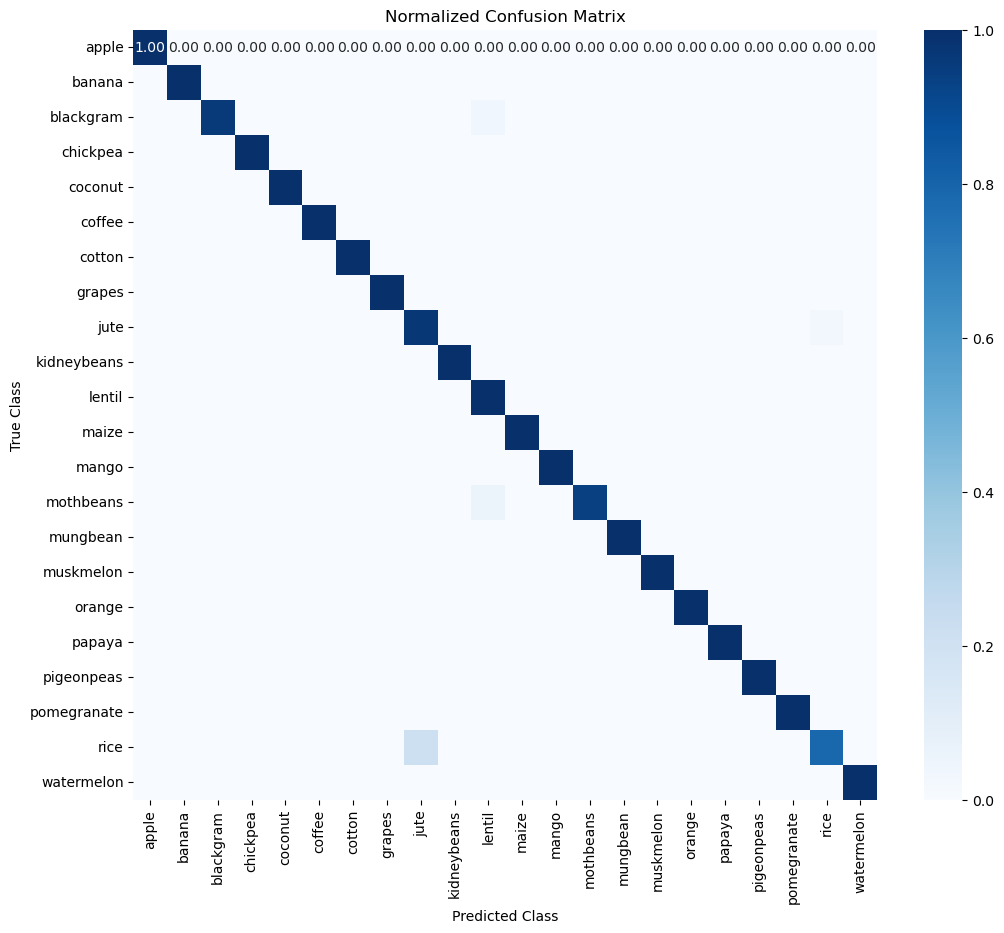

In [241]:
plot_confusion_matrix(y_test, y_pred_sc_rf)

In [242]:
# Evaluate the Stacking Classifier with Random Forest. Get the Accuracy, F1 scores, Macro F1 score and weighted F1 score

sc_rf_accuracy = accuracy_score(y_test, y_pred_sc_rf)
sc_rf_f1_scores = get_f1_scores(y_test, y_pred_sc_rf)
sc_rf_macro_f1_score = f1_score(y_test, y_pred_sc_rf, average='macro')
sc_rf_weighted_f1_score = f1_score(y_test, y_pred_sc_rf, average='weighted')
print(f'Stacking Classifier with RandomForest Accuracy: {sc_rf_accuracy:.2f}')
print(f'Stacking Classifier with RandomForest Macro F1 score: {sc_rf_macro_f1_score:.2f}')
print(f'Stacking Classifier with RandomForest Weighted F1 score: {sc_rf_weighted_f1_score:.2f}')
print('Stacking Classifier with RandomForest F1 scores for each class:')
print(sc_rf_f1_scores)

Stacking Classifier with RandomForest Accuracy: 0.98
Stacking Classifier with RandomForest Macro F1 score: 0.98
Stacking Classifier with RandomForest Weighted F1 score: 0.98
Stacking Classifier with RandomForest F1 scores for each class:
{'rice': 1.0, 'maize': 1.0, 'chickpea': 0.9803921568627451, 'kidneybeans': 1.0, 'pigeonpeas': 1.0, 'mothbeans': 1.0, 'mungbean': 1.0, 'blackgram': 1.0, 'lentil': 0.9041095890410958, 'pomegranate': 1.0, 'banana': 0.9361702127659575, 'mango': 1.0, 'grapes': 1.0, 'watermelon': 0.9696969696969697, 'muskmelon': 1.0, 'apple': 1.0, 'orange': 1.0, 'papaya': 1.0, 'coconut': 1.0, 'cotton': 1.0, 'jute': 0.8627450980392156, 'coffee': 1.0}


## 8. Stacking Classifier with Decision Trees

In [243]:
# Use KNN, Logistic Regression, Support Vector Machine and Decision Tree Classifiers with the best params
# from above as base models to stacking classifier.
base_models = [
    ('knn', knn_grid),
    ('lgr', lgr_grid),
    ('svc', svm_grid),
    ('dt', dt_grid)
]

# Decision Tree as meta model
meta_model = DecisionTreeClassifier(random_state=42)
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacking_clf.fit(X_train, y_train)
y_pred_sc_dt = stacking_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_sc_dt)
print(accuracy)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

0.9757575757575757


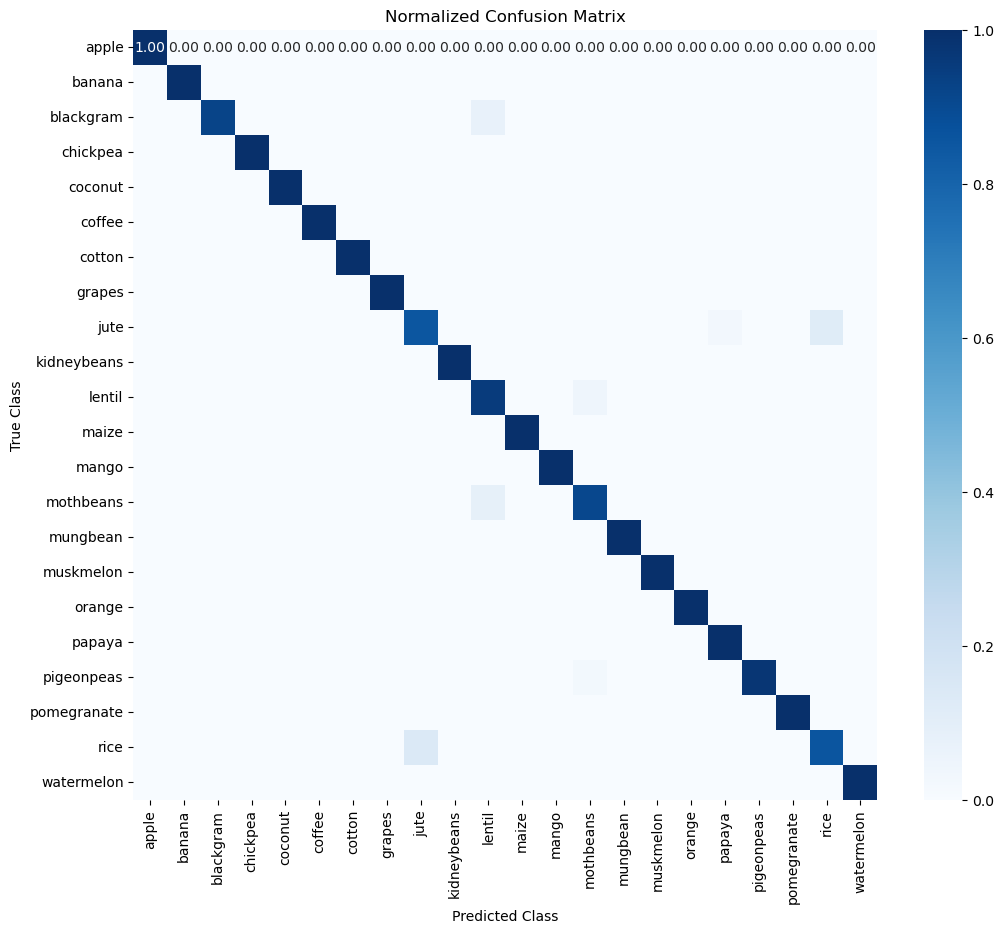

In [244]:
plot_confusion_matrix(y_test, y_pred_sc_dt)

In [245]:
# Evaluate the Stacking Classifier with Decision Tree. Get the Accuracy, F1 scores, Macro F1 score and weighted F1 score
sc_dt_accuracy = accuracy_score(y_test, y_pred_sc_dt)
sc_dt_f1_scores = get_f1_scores(y_test, y_pred_sc_dt)
sc_dt_macro_f1_score = f1_score(y_test, y_pred_sc_dt, average='macro')
sc_dt_weighted_f1_score = f1_score(y_test, y_pred_sc_dt, average='weighted')
print(f'Stacking Classifier with DecisionTree Accuracy: {sc_dt_accuracy:.2f}')
print(f'Stacking Classifier with DecisionTree Macro F1 score: {sc_dt_macro_f1_score:.2f}')
print(f'Stacking Classifier with DecisionTree Weighted F1 score: {sc_dt_weighted_f1_score:.2f}')
print('Stacking Classifier with DecisionTree F1 scores for each class:')
print(sc_dt_f1_scores)

Stacking Classifier with DecisionTree Accuracy: 0.98
Stacking Classifier with DecisionTree Macro F1 score: 0.98
Stacking Classifier with DecisionTree Weighted F1 score: 0.98
Stacking Classifier with DecisionTree F1 scores for each class:
{'rice': 1.0, 'maize': 1.0, 'chickpea': 0.9600000000000001, 'kidneybeans': 1.0, 'pigeonpeas': 1.0, 'mothbeans': 1.0, 'mungbean': 1.0, 'blackgram': 1.0, 'lentil': 0.8656716417910447, 'pomegranate': 1.0, 'banana': 0.875, 'mango': 1.0, 'grapes': 1.0, 'watermelon': 0.9253731343283583, 'muskmelon': 1.0, 'apple': 1.0, 'orange': 1.0, 'papaya': 0.9866666666666666, 'coconut': 0.9863013698630138, 'cotton': 1.0, 'jute': 0.8571428571428571, 'coffee': 1.0}


## 9. Stacking Classifier with KNN

In [246]:
# Use KNN, Logistic Regression, Support Vector Machine and Decision Tree Classifiers with the best params
base_models = [
    ('knn', knn_grid),
    ('lgr', lgr_grid),
    ('svc', svm_grid),
    ('dt', dt_grid)
]
# KNearest Neighbors Classifier as meta model
meta_model = KNeighborsClassifier()
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacking_clf.fit(X_train, y_train)
y_pred_sc_knn = stacking_clf.predict(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

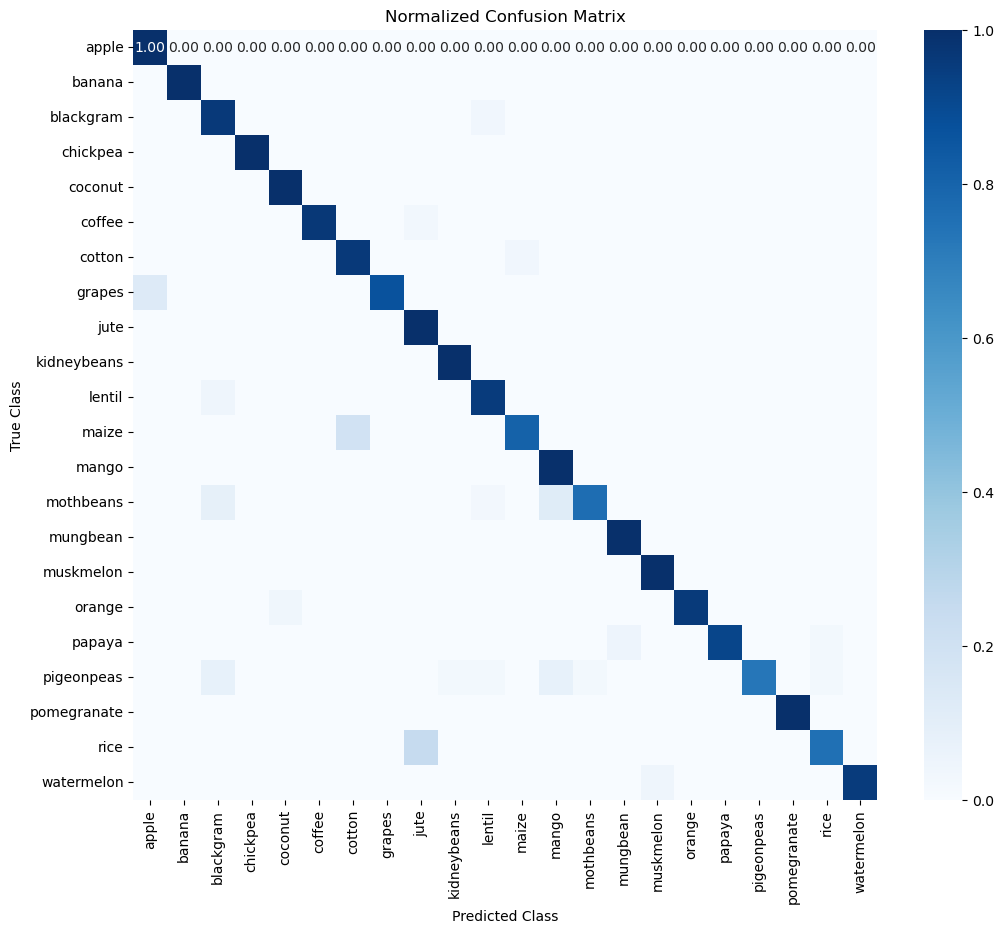

In [247]:
plot_confusion_matrix(y_test, y_pred_sc_knn)

In [248]:
# Evaluate the Stacking Classifier with KNN. Get the Accuracy, F1 scores, Macro F1 score and weighted F1 score
sc_knn_accuracy = accuracy_score(y_test, y_pred_sc_knn)
sc_knn_f1_scores = get_f1_scores(y_test, y_pred_sc_knn)
sc_knn_macro_f1_score = f1_score(y_test, y_pred_sc_knn, average='macro')
sc_knn_weighted_f1_score = f1_score(y_test, y_pred_sc_knn, average='weighted')
print(f'Stacking Classifier with KNN Accuracy: {sc_knn_accuracy:.2f}')
print(f'Stacking Classifier with KNN Macro F1 score: {sc_knn_macro_f1_score:.2f}')
print(f'Stacking Classifier with KNN Weighted F1 score: {sc_knn_weighted_f1_score:.2f}')
print('Stacking Classifier with KNN F1 scores for each class:')
print(sc_knn_f1_scores)

Stacking Classifier with KNN Accuracy: 0.94
Stacking Classifier with KNN Macro F1 score: 0.94
Stacking Classifier with KNN Weighted F1 score: 0.94
Stacking Classifier with KNN F1 scores for each class:
{'rice': 0.9577464788732395, 'maize': 1.0, 'chickpea': 0.8620689655172413, 'kidneybeans': 1.0, 'pigeonpeas': 0.9850746268656716, 'mothbeans': 0.983050847457627, 'mungbean': 0.8999999999999999, 'blackgram': 0.9302325581395349, 'lentil': 0.8947368421052632, 'pomegranate': 0.9863013698630138, 'banana': 0.9130434782608695, 'mango': 0.875, 'grapes': 0.9014084507042254, 'watermelon': 0.8524590163934426, 'muskmelon': 0.967741935483871, 'apple': 0.9795918367346939, 'orange': 0.9795918367346939, 'papaya': 0.9577464788732395, 'coconut': 0.8437499999999999, 'cotton': 1.0, 'jute': 0.8235294117647057, 'coffee': 0.9777777777777777}


### Plot F1 scores for all classes from the above 5 Stacking Classifier Models

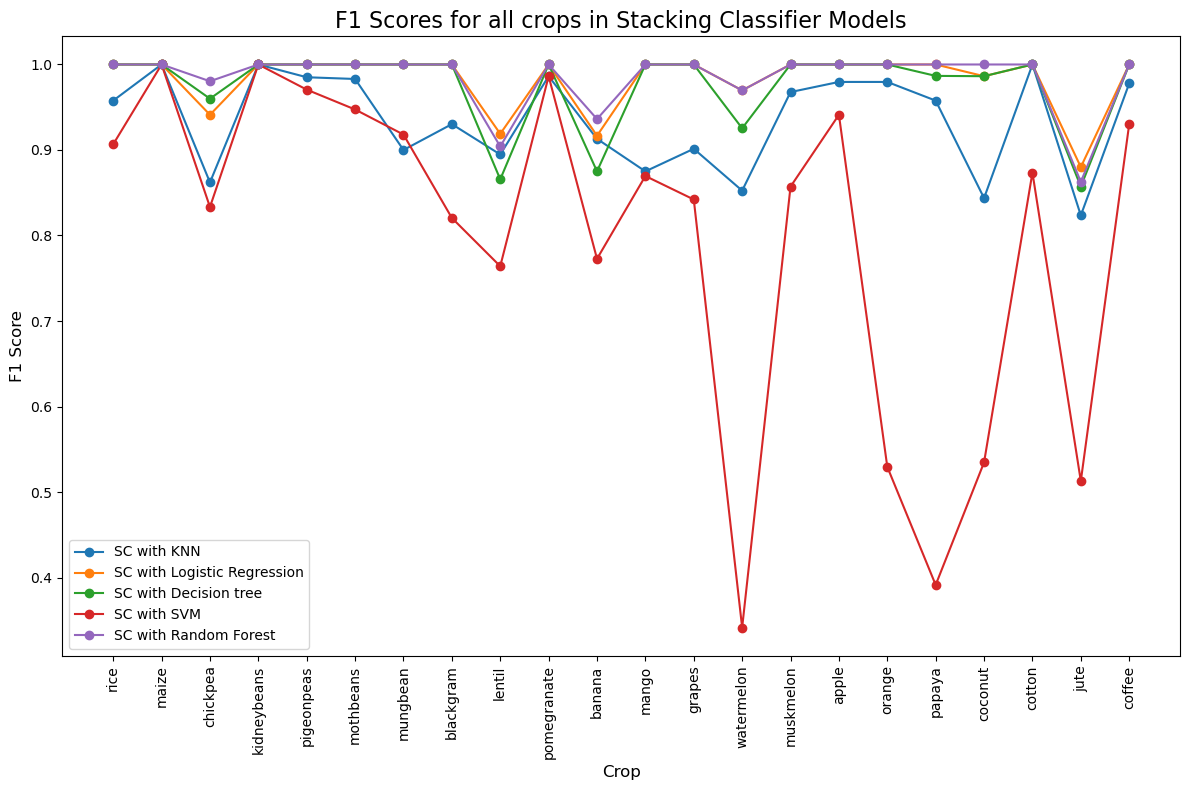

In [249]:
f1_scores = {
    'SC with KNN': sc_knn_f1_scores.values(),
    'SC with Logistic Regression': sc_lgr_f1_scores.values(),
    'SC with Decision tree': sc_dt_f1_scores.values(),
    'SC with SVM': sc_svm_f1_scores.values(),
    'SC with Random Forest': sc_rf_f1_scores.values()
}

# Define the figure size
plt.figure(figsize=(12, 8))

# Plot F1 scores for each model as a line
for model, scores in f1_scores.items():
    plt.plot(crop_labels, scores, marker='o', label=model)

# Adding labels and title
plt.xlabel('Crop', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('F1 Scores for all crops in Stacking Classifier Models', fontsize=16)

# Rotate class names on x-axis
plt.xticks(rotation=90)

# Add a legend to differentiate the models
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [250]:
# Plot accuracy for each model
sc_model_accuracy = {
    'Model': ['SC-Logistic Regression', 'SC-Decision Tree', 'SC-SVM', 'SC-KNN', 'SC-RandomForest'],
    'Accuracy': [sc_lgr_accuracy, sc_dt_accuracy, sc_svm_accuracy, sc_knn_accuracy, sc_rf_accuracy],
    'Macro F1 score': [sc_lgr_macro_f1_score, sc_dt_macro_f1_score, sc_svm_macro_f1_score, sc_knn_macro_f1_score, sc_rf_macro_f1_score], 
    'Weighted F1 score': [sc_lgr_weighted_f1_score, sc_dt_weighted_f1_score, sc_svm_weighted_f1_score, sc_knn_weighted_f1_score, sc_rf_weighted_f1_score]
}

# Display the results
sc_accuracy_df = pd.DataFrame(sc_model_accuracy)
print(sc_accuracy_df)

                    Model  Accuracy  Macro F1 score  Weighted F1 score
0  SC-Logistic Regression  0.983333        0.982398           0.983308
1        SC-Decision Tree  0.975758        0.975280           0.975917
2                  SC-SVM  0.812121        0.797410           0.790786
3                  SC-KNN  0.936364        0.935039           0.935455
4         SC-RandomForest  0.984848        0.984232           0.984776


In [251]:
print(accuracy_df)

                 Model  Accuracy  Macro F1 score  Weighted F1 score
0  Logistic Regression  0.971212        0.971514           0.970881
1        Decision Tree  0.986364        0.986270           0.986273
2                  SVM  0.980303        0.979397           0.980392
3                  KNN  0.971212        0.970574           0.971315


### Analysis
Stacking Classifier with Random forest gave highest accuracy amond stacking classifier models.
However, since the accuracy of Decision Tree and Stacking Classifier with Random forest are almost same, we need to come up with a metric to choose one of the two.

## Using Cross-Validation to find better model

In [252]:
# Import necessary libraries
from sklearn.model_selection import cross_val_score, KFold
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
import numpy as np

# Define k-fold cross-validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation using accuracy as the metric
dt_cv_scores = cross_val_score(dt_grid, X, y, cv=kf, scoring='accuracy')

# Display the cross-validation scores
print(f"Decision Tree Cross-validation scores for {k} folds: {dt_cv_scores}")
print(f"Decision Tree Mean accuracy: {np.mean(dt_cv_scores):.4f}")
print(f"Decision Tree Standard deviation of accuracy: {np.std(dt_cv_scores):.4f}")

Decision Tree Cross-validation scores for 5 folds: [0.98636364 0.97954545 0.99772727 0.98181818 0.98409091]
Decision Tree Mean accuracy: 0.9859
Decision Tree Standard deviation of accuracy: 0.0063


In [253]:
base_models = [
    ('knn', knn_grid),
    ('lgr', lgr_grid),
    ('svc', svm_grid),
    ('dt', dt_grid)
]
meta_model = RandomForestClassifier(random_state=42)
sc_rf_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Perform cross-validation using accuracy as the metric
sc_rf_cv_scores = cross_val_score(sc_rf_clf, X, y, cv=kf, scoring='accuracy')


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

In [254]:
# Display the cross-validation scores
print(f"Stacking Classifier with RandomForest Cross-validation scores for {k} folds: {sc_rf_cv_scores}")
print(f"Stacking Classifier with RandomForest Mean accuracy: {np.mean(sc_rf_cv_scores):.4f}")
print(f"Stacking Classifier with RandomForest Standard deviation of accuracy: {np.std(sc_rf_cv_scores):.4f}")

Stacking Classifier with RandomForest Cross-validation scores for 5 folds: [0.98181818 0.98181818 0.99318182 0.99772727 0.99545455]
Stacking Classifier with RandomForest Mean accuracy: 0.9900
Stacking Classifier with RandomForest Standard deviation of accuracy: 0.0068


Since Stacking classifier with Random Forest has higher mean accuracy when compared to Decision Tree, it is chosen as the best model for crop recommendation.

## Important Features
Using permutation importance technique to find the most important features for crop prediction.

In [255]:
best_model_for_crop_recommendation = sc_rf_clf
best_model_for_crop_recommendation.fit(X_train, y_train)
y_pred_best_model = best_model_for_crop_recommendation.predict(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.p

In [256]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
result = permutation_importance(best_model_for_crop_recommendation, X_test, y_test, n_repeats=30, random_state=42)

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean,
    'Std Dev': result.importances_std
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("\nPermutation Importance of Features:")
print(importance_df)


Permutation Importance of Features:
       Feature  Importance   Std Dev
4     humidity    0.380000  0.018010
6     rainfall    0.325101  0.014870
0            N    0.250505  0.012022
1            P    0.202071  0.013212
2            K    0.193535  0.010504
3  temperature    0.095303  0.010914
5           ph    0.043788  0.006632


## Crop Rotation
Find a group of crops that can grow in similar soil and climate conditions

### KMeans Clustering
Use KMeans clustering technique to find groups of crops that can grow in similar conditions

Choose the two most important features, 'humidity', 'rainfall'

**Rationale:**
- **Visualization:**
With only 2 features, you can easily create a 2D scatter plot, making it straightforward to visualize the clusters formed by the K-Means algorithm.
This can provide immediate insight into how well-defined the clusters are.

- **Simplicity:**
Fewer dimensions can simplify interpretation and analysis.
It reduces the risk of overfitting, especially in cases where the dataset is small or has many features relative to the number of observations.

In [257]:
# Choose two most important features for KMeans
best_X = crop[['humidity', 'rainfall']]
best_y = crop['label']

In [258]:
best_X

,humidity,rainfall
0,82.002744,202.935536
1,80.319644,226.655537
2,82.320763,263.964248
3,80.158363,242.864034
4,81.604873,262.717340
...,...,...
2195,66.413269,177.774507
2196,56.636362,127.924610
2197,67.225123,173.322839
2198,52.127394,127.175293


In [259]:
best_y

0         rice
1         rice
2         rice
3         rice
4         rice
         ...  
2195    coffee
2196    coffee
2197    coffee
2198    coffee
2199    coffee
Name: label, Length: 2200, dtype: object

### Using Elbow method to find the optimal number of clusters for this dataset

In [260]:
scalar = StandardScaler()
best_X_scaled = scalar.fit_transform(best_X)

from sklearn.cluster import KMeans

inertia = []
for k in range(1, len(crop_labels)):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(best_X_scaled)
    inertia.append(kmeans.inertia_)

# List of inertial proportion i.e the rate of change of inertia as number of clusters increases.
inertia_proportion = []
for i in range(1, len(inertia)):
    inertia_proportion.append(abs(inertia[i-1]-inertia[i]) / inertia[i-1])
    
print(inertia_proportion)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of

[0.36801515696320536, 0.49152421521074724, 0.27068545322991205, 0.26502595347709745, 0.27086792712544244, 0.15890688383099033, 0.16792073286400805, 0.15003983019852107, 0.10346857298946875, 0.09230645462319885, 0.08923200078744711, 0.10220801673441131, 0.10557347944090416, 0.09163097423158136, 0.08198921478608537, 0.08742908365662914, 0.09205662921867919, 0.06001024005055696, 0.06699029264941274, 0.059005478440840683]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



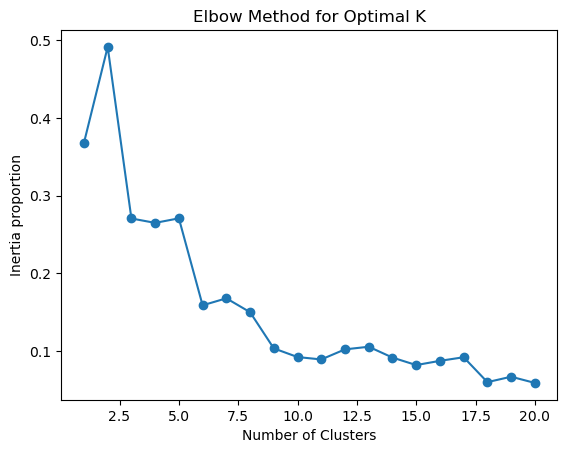

In [261]:
plt.plot(range(1, 21), inertia_proportion, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia proportion')
plt.title('Elbow Method for Optimal K')
plt.show()

### Analysis
The rate of change of inertia is the most from n_clusters=4 to n_clusters=5.
There is further decrease in inertial from 5 to 6 and almost negligible from 6 to 7.
Hence, choosing n_clusters = 6 for optimal number of clusters.

In [262]:
# Optimal k = 6
# Apply K-Means clustering
import plotly.express as px

kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(best_X_scaled)

# Add cluster labels to the DataFrame
kmeans_df = pd.DataFrame(best_X, columns=best_X.columns)
kmeans_df['Cluster'] = clusters
kmeans_df['label'] = best_y

# Inverse transform the centroids to the original scale
centroids_original = scalar.inverse_transform(kmeans.cluster_centers_)

# Plot with Plotly
fig = px.scatter(kmeans_df, 
                 x=kmeans_df.columns[0],
                 y=kmeans_df.columns[1],
                 color='Cluster',          # Color by cluster label
                 title=f"K-Means Clustering with k={6}",
                 labels={'x': kmeans_df.columns[0], 'y': kmeans_df.columns[1]},
                 hover_data={'label': True, 'humidity': True, 'rainfall': True})

# Add cluster centroids
fig.add_scatter(x=centroids_original[:, 0], y=centroids_original[:, 1],
                mode='markers', marker=dict(color='red', size=12, symbol='x'),
                name='Centroids')

# Show the plot
fig.show()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [263]:
# Construct dictionary of crop name to count for each cluster
crop_count_dict = {}

# Group by cluster and count crops
for cluster, group in kmeans_df.groupby('Cluster'):
    crop_counts = group['label'].value_counts()
    crop_count_dict[cluster] = crop_counts.to_dict()  # Convert to dictionary

crop_count_df = pd.DataFrame.from_dict(crop_count_dict).fillna(-1)
crop_count_df.replace(-1, '-', inplace=True)
# Display the resulting dictionary
print(crop_count_df)

                 0     1      2      3      4      5
rice         100.0     -      -      -      -      -
jute          73.0  13.0      -      -   14.0      -
coconut       61.0     -      -      -   39.0      -
papaya        43.0     -      -   25.0   32.0      -
coffee         2.0  97.0      -      -    1.0      -
pigeonpeas       -  80.0    9.0      -      -   11.0
chickpea         -     -  100.0      -      -      -
kidneybeans      -     -  100.0      -      -      -
mungbean         -     -      -  100.0      -      -
grapes           -     -      -  100.0      -      -
watermelon       -     -      -  100.0      -      -
muskmelon        -     -      -  100.0      -      -
cotton           -     -      -   56.0   44.0      -
pomegranate      -     -      -      -  100.0      -
banana           -     -      -      -  100.0      -
apple            -     -      -      -  100.0      -
orange           -     -      -      -  100.0      -
maize            -     -      -      -   11.0 

## Findings

- Stacking Classifier with Random Forest as final estimator gave optimal accuracy. This can be chosen to predict the crop that can be grown in a field, given the soil and climatic conditions.

**Crop Rotation**
- Mothbeans, Blackgram, Mango and Maize can be grown in similar fields
- Rice can be grown in similar fields as to coconut
- Chickpea and Kidney beans can be grown in similar fields
- Mungbean, grapes, watermelon, muskmelon and cotton can be grown in similar fields
- Pomegranate, banana, apple and orange can be grown in similar fields